In [8]:
# !pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install --upgrade pip
# !pip install praat-parselmouth
# !pip install pycwt

from data_utils import AudioTextProcessor
from text import text_to_sequence
from utils import pitch_utils
from utils import tools
import audio as Audio

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import yaml

preprocess_config = yaml.load(open('./config/kss/preprocess.yaml', "r"), Loader=yaml.FullLoader)
processor = AudioTextProcessor(preprocess_config)

In [2]:
wav_path = './kss/1/1_0003.wav'

wav, duration = processor.load_audio(wav_path)
mel, energy = Audio.tools.get_mel_from_wav(wav, processor.STFT)
mel, energy = mel[:,:duration], energy[:duration]
f0, pitch_coarse = pitch_utils.get_pitch(wav, mel.T, processor.preprocess_config)
f0, pitch_coarse = f0[:duration], pitch_coarse[:duration]

cwt_spec, cwt_scales, cwt_mean_std = pitch_utils.get_f0cwt(f0)
cwt_mean = cwt_mean_std[0]
cwt_std = cwt_mean_std[1]

cwt_spec = torch.FloatTensor(cwt_spec).unsqueeze(0)
cwt_mean = torch.FloatTensor([float(cwt_mean)])
cwt_std = torch.FloatTensor([float(cwt_std)])

In [3]:
text = "그는 아내를 많이 아낀다."
sequence = text_to_sequence(text)

duration_rounded = [26]*7
duration_rounded[-1] += 1
print(sum(duration_rounded))
print(mel.shape[-1])


duration_rounded = torch.LongTensor(duration_rounded).unsqueeze(0)
mel2ph = pitch_utils.dur_to_mel2ph(duration_rounded, None)

processor.preprocess_config["preprocessing"]["pitch"]['cwt_scales'] = cwt_scales
processor.preprocess_config["preprocessing"]["pitch"]['pitch_norm'] = "log"
processor.preprocess_config["preprocessing"]["pitch"]['pitch_norm_eps'] = 0.000000001
f0_norm = pitch_utils.cwt2f0_norm(
    cwt_spec, cwt_mean, cwt_std, mel2ph, processor.preprocess_config["preprocessing"]["pitch"])
f0_norm = f0_norm.squeeze().detach().cpu().numpy()
f0_denorm = pitch_utils.denorm_f0(f0_norm, None, processor.preprocess_config["preprocessing"]["pitch"])
pitch_from_f0 = pitch_utils.f0_to_coarse(f0_denorm)

183
183


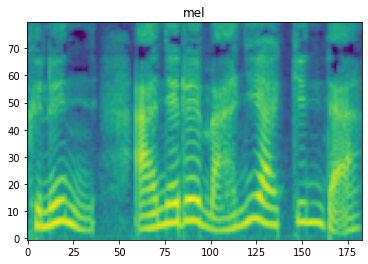

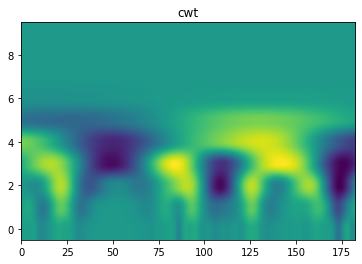

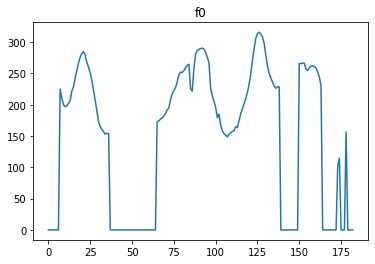

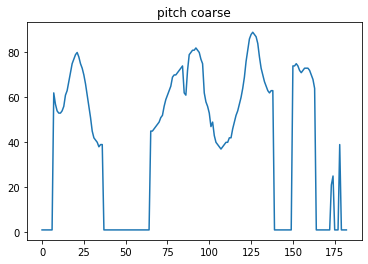

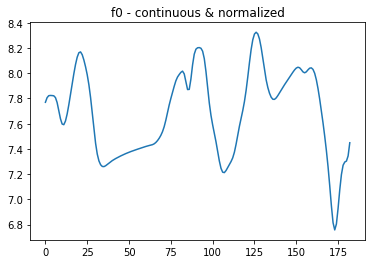

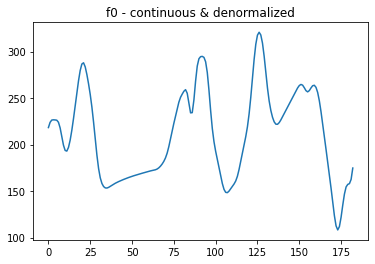

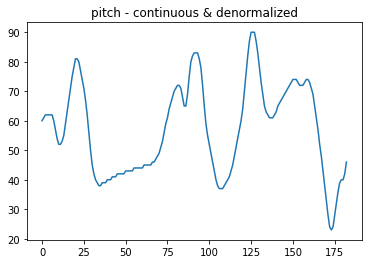

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.imshow(mel, origin='lower', aspect='auto')
plt.title('mel')
plt.show()

plt.imshow(cwt_spec.T, origin='lower', aspect='auto')
plt.title('cwt')
plt.show()

plt.plot(f0)
plt.title('f0')
plt.show()

plt.plot(pitch_coarse)
plt.title('pitch coarse')
plt.show()

plt.plot(f0_norm)
plt.title('f0 - continuous & normalized')
plt.show()

plt.plot(f0_denorm)
plt.title('f0 - continuous & denormalized')
plt.show()

plt.plot(pitch_from_f0)
plt.title('pitch - continuous & denormalized')
plt.show()
